CartPole Intro

by Jack Curcio

This notebook is a proof of concept for instantiating the Cartpole environment using OpenAI's gymnasium library. I set up recording videos and relevant functions to save and display videos using Google Colab.

Random actions are made across 100 episodes, with the 1st, 50th, and 100th episode being recorded and saved.

OpenAI gym documentation:
https://gymnasium.farama.org/introduction/basic_usage/

In [4]:
!pip install gymnasium torch matplotlib
!pip install pyvirtualdisplay
!sudo apt-get install xvfb

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.14).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


Action Space: Discrete(2)
Observation Space: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
Max Episode Steps: 500
Nondeterministic: False
Reward Threshold: 475.0


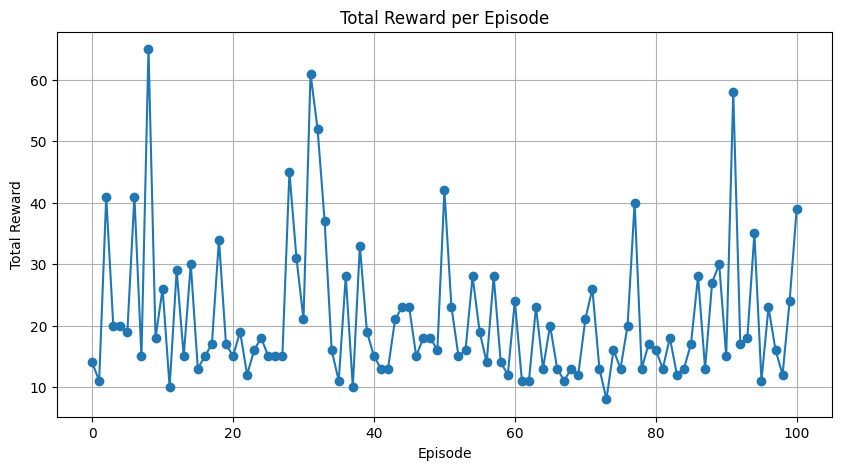

Displaying video for episode 1


Displaying video for episode 50


Displaying video for episode 100


In [3]:
import gymnasium as gym
import matplotlib.pyplot as plt
from gymnasium.wrappers import RecordVideo
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
import re

#helper function to understand more abt the env
def query_environment(name):
    env = gym.make(name)
    spec = gym.spec(name)
    print(f"Action Space: {env.action_space}")
    print(f"Observation Space: {env.observation_space}")
    print(f"Max Episode Steps: {spec.max_episode_steps}")
    print(f"Nondeterministic: {spec.nondeterministic}")
    print(f"Reward Threshold: {spec.reward_threshold}")

query_environment("CartPole-v1")

#helper function to record the 0, 20, 40, 60, 80, and 100th episodes
def record_first_and_every_20th(episode_id):
    return episode_id == 1 or episode_id % 50 == 0


#helpers to view videos in colab
# Start virtual display
display = Display(visible=0, size=(1000, 1000))
display.start()

# Initialise the environment - render mode has to be rgb array to display using this method ?
env = gym.make("CartPole-v1", render_mode="rgb_array")
env.metadata['render_fps'] = 30

# Setup the wrapper to record the video
env = RecordVideo(env, video_folder='./videos', episode_trigger=record_first_and_every_20th)

# Reset the environment to generate the first observation
observation, info = env.reset()

#keep track of episode rewards to plot later + run for 100 episodes
episode_rewards = []
num_episodes = 101

for episode in range(num_episodes):
    observation, info = env.reset()
    total_reward = 0
    done = False

    while not done:
        #policy (random)
        action = env.action_space.sample()
        #step through env with action
        observation, reward, terminated, truncated, info = env.step(action)
        #increase reward for this episode
        total_reward += reward
        #terminate episode if ended
        done = terminated or truncated
    #add rewards to list to be plotted later
    episode_rewards.append(total_reward)

#Close env as we are done using it
env.close()

#plot
plt.figure(figsize=(10, 5))
plt.plot(episode_rewards, marker='o')
plt.title('Total Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)
plt.show()


video_files = glob.glob('./videos/*.mp4')

def get_episode_id(filename):
    # works for both gymnasium and gym
    match = re.search(r'episode-(\d+)', filename)
    if match:
        return int(match.group(1))
    return -1

# Filter and sort video files with episode id > 0
filtered_videos = [vf for vf in video_files if get_episode_id(vf) > 0]
filtered_videos.sort(key=get_episode_id)  # Optional: sort by episode id

for video_file in filtered_videos:
    episode_id = get_episode_id(video_file)
    print(f"Displaying video for episode {episode_id}")
    video = io.open(video_file, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data=f'''
        <video width="640" height="480" controls>
            <source src="data:video/mp4;base64,{encoded.decode('ascii')}" type="video/mp4" />
        </video>
        <p>Episode {episode_id}</p>
    '''))